# 1. Import and explore the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('signal-data.csv')

In [3]:
independent_feature_columns = data.drop(labels=['Pass/Fail'], axis=1).columns

In [4]:
data.shape

(1567, 592)

**Observations:**<br/>
We can see there are 1567 number of records in our data set and the data has 592 features.

In [5]:
data.head()

Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045  99.3032   

      586     587     588       589  Pass/Fail  
0     NaN     NaN     NaN       NaN         -1  
1  0.0096  0.0201  0.0060  208.2045         -1  
2  0.0584  0.0484  0.0148   82.8602          1  
3  0.0202  0.0149  0.0044   73.8432         -1  
4  0.0202  0.0149  0.0044   73.8432         -1  

[5 rows x 592 columns]

In [6]:
data.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

**Observations:**<br/>
All the features in the data set are of 3 different data types. As except the Time independent feature, all other independent features are of data type float64, it's clear there are are no junk values in these columns.

# 2. Data cleansing:

In [7]:
data.isna().sum()

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

In [8]:
# columns with more than 50% missing data

column_with_missing_data = []

for column in data.columns:
    missing_value_percentage = data[column].isnull().sum()/data.shape[0]*100
    if missing_value_percentage > 50:
        column_with_missing_data.append(column)

In [9]:
len(column_with_missing_data)

28

**Observations:**<br/>
As we can see there are 28 features for which more than 50% data is missing. So, we will not impute these missing data as it will affect the performance of the model in production. Instead we'll drop these features.

In [10]:
data = data.drop(labels=column_with_missing_data, axis=1)

**Observations:**<br/>
Now, we can impute the missing data in rest of the features. We'll impute these data with the respective medians.

In [11]:
from sklearn.impute import SimpleImputer

contFeatureImputer = SimpleImputer(missing_values=np.nan, strategy='median')

columns = data.drop(labels=['Time', 'Pass/Fail'], axis=1).columns

In [12]:
for column in columns:
    data[[column]] = contFeatureImputer.fit_transform(data[[column]])

In [13]:
data.isna().sum()

Time         0
0            0
1            0
2            0
3            0
            ..
586          0
587          0
588          0
589          0
Pass/Fail    0
Length: 564, dtype: int64

**Observations:**<br/>
Missing values in all the features have been imputed with the respective column medians.

In [14]:
# Lets check for columns with having same values for all the record, these features are not of importance 
# for the model building and can be dropped.

unique_col_list = []

for column in data.columns:
    if data[column].nunique() == 1:
        unique_col_list.append(column)

In [15]:
len(unique_col_list)

116

**Observatrions:**<br/>
As we can see in our data set, 116 features are having same values for all the records. So, these features can be dropped as these are of no importance for the model building.

In [16]:
data = data.drop(labels=unique_col_list, axis=1)

In [17]:
data.shape

(1567, 448)

As there are 564 continuous features, we can check for multicolinearity and drop columns which are strongly correlated to each other.

In [18]:
corr_mat = data.drop(labels=['Time', 'Pass/Fail'], axis=1).corr().abs()

In [19]:
# Below code snipet will check for the features with high correlation magnitude.

def remove_collinear_features(corr_matrix, threshold):
    
    correlated_features_set = set([])
    iteration = range(0, len(corr_matrix.columns)-1)
    
    for i in iteration:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            if val >= threshold:
                correlated_features_set.add(col.values[0])
    
    
    return list(correlated_features_set)

In [20]:
# For our analysis we have considered the correlation magnitude threshold as 0.80 (i.e. Features having 
# correlation magnitude more than 0.80 will be considered as highly correlated and can be dropped.)

correlated_features_list = remove_collinear_features(corr_mat, 0.85)

In [21]:
len(correlated_features_list)

211

As we are going to drop columns which have high correlation magnitude, we'll make a copy of the cleaned data and work on that.

In [22]:
workingCopy = data.copy(deep=True)

In [23]:
workingCopy = workingCopy.drop(labels=correlated_features_list, axis=1)

In [24]:
workingCopy.shape

(1567, 237)

**Observations:**<br/>
We have removed 211 features which had high correlation magnitude.

In [25]:
def getManufacturingYears(data):
    years = set([])
    
    for value in data['Time']:
        years.add(value[:4])
        
    return years

In [26]:
years = getManufacturingYears(workingCopy)

In [27]:
years

{'2008'}

**Observations:**<br/>

As we can see all the data has been collected for the semicondutors manufactures in a year(i.e. 2008). We can drop the data time column as this is not of much significance.

In [28]:
workingCopy = workingCopy.drop(labels=['Time'], axis=1)

# 3. Data analysis & visualisation:

https://www.kaggle.com/kirshoff/secom-dataset-analysis

In [29]:
workingCopy.describe().T

count         mean         std        min         25%        50%  \
0          1567.0  3014.441551   73.480841  2743.2400  2966.66500  3011.4900   
1          1567.0  2495.866110   80.228143  2158.7500  2452.88500  2499.4050   
2          1567.0  2200.551958   29.380973  2060.6600  2181.09995  2201.0667   
3          1567.0  1395.383474  439.837330     0.0000  1083.88580  1285.2144   
4          1567.0     4.171281   56.103721     0.6815     1.01770     1.3168   
...           ...          ...         ...        ...         ...        ...   
583        1567.0     0.015317    0.017174     0.0060     0.01160     0.0138   
586        1567.0     0.021458    0.012354    -0.0169     0.01345     0.0205   
587        1567.0     0.016474    0.008805     0.0032     0.01060     0.0148   
589        1567.0    99.652345   93.864558     0.0000    44.36860    71.9005   
Pass/Fail  1567.0    -0.867262    0.498010    -1.0000    -1.00000    -1.0000   

                 75%        max  
0          3056.5400  3356.3500  
1          2538.7450  2846.4400  
2          2218.0555  2315.2667  
3          1590.1699  3715.0417  
4             1.5188  1114.5366  
...              ...        ...  
583           0.0165     0.4766  
586           0.0276     0.1028  
587           0.0203     0.0799  
589         114.7497   737.3048  
Pass/Fail    -1.0000     1.0000  

[236 rows x 8 columns]

In [30]:
sns.countplot(data=workingCopy, x='Pass/Fail')

<AxesSubplot:xlabel='Pass/Fail', ylabel='count'>

**Observations:**<br/>
As we can see the data in the target feature is imbalanced. So, we might have to balance the dataset to be able to make the model efficient.

In [31]:
workingCopy.corr()

0         1         2         3         4         6  \
0          1.000000 -0.144161  0.004667 -0.006665 -0.010819  0.002028   
1         -0.144161  1.000000  0.005883 -0.008963 -0.001917 -0.025222   
2          0.004667  0.005883  1.000000  0.298810  0.095881 -0.136212   
3         -0.006665 -0.008963  0.298810  1.000000 -0.058351 -0.685773   
4         -0.010819 -0.001917  0.095881 -0.058351  1.000000 -0.074395   
...             ...       ...       ...       ...       ...       ...   
583        0.023562  0.002863  0.015694  0.025288 -0.001331 -0.039425   
586        0.018534 -0.009430 -0.025506  0.035164 -0.043831 -0.041299   
587       -0.025867  0.017056 -0.029287 -0.039196 -0.031012  0.034113   
589        0.004185  0.044552 -0.032763 -0.080942  0.050792  0.044039   
Pass/Fail -0.025100 -0.002542 -0.000999 -0.024014 -0.013633  0.016085   

                  7         8         9        10  ...       570       571  \
0          0.031347 -0.052735  0.009091  0.006445  ... -0.018987 -0.023194   
1         -0.011761  0.031244  0.024025  0.009529  ... -0.008994 -0.037897   
2         -0.147116  0.023524  0.016248  0.069902  ... -0.037054 -0.015672   
3          0.086965 -0.102839  0.066987  0.049785  ...  0.002004 -0.016797   
4         -0.343413 -0.025933  0.053973 -0.006496  ...  0.005227 -0.081776   
...             ...       ...       ...       ...  ...       ...       ...   
583        0.010378  0.017336 -0.036119  0.039193  ...  0.010498  0.006717   
586        0.058019  0.010418  0.033700  0.000329  ...  0.020535 -0.056392   
587       -0.021518  0.022793  0.059181  0.046995  ...  0.008090 -0.010567   
589       -0.107904 -0.022864  0.004670  0.008462  ... -0.010618  0.010945   
Pass/Fail  0.012891  0.028022 -0.031180  0.033630  ... -0.001656 -0.019353   

                572       573       582       583       586       587  \
0          0.013715 -0.002035  0.000190  0.023562  0.018534 -0.025867   
1          0.001705 -0.011468  0.043754  0.002863 -0.009430  0.017056   
2         -0.000554 -0.030714 -0.005971  0.015694 -0.025506 -0.029287   
3          0.008152  0.013742  0.008305  0.025288  0.035164 -0.039196   
4         -0.011918 -0.016415  0.044943 -0.001331 -0.043831 -0.031012   
...             ...       ...       ...       ...       ...       ...   
583       -0.017388 -0.022777 -0.190091  1.000000  0.002258 -0.002566   
586       -0.008657 -0.013498 -0.016729  0.002258  1.000000  0.167920   
587       -0.001398 -0.018881 -0.024507 -0.002566  0.167920  1.000000   
589       -0.022629 -0.027130  0.041449 -0.002928 -0.486530  0.390834   
Pass/Fail -0.032233 -0.051873  0.047015  0.005996  0.004170  0.035423   

                589  Pass/Fail  
0          0.004185  -0.025100  
1          0.044552  -0.002542  
2         -0.032763  -0.000999  
3         -0.080942  -0.024014  
4          0.050792  -0.013633  
...             ...        ...  
583       -0.002928   0.005996  
586       -0.486530   0.004170  
587        0.390834   0.035423  
589        1.000000  -0.002603  
Pass/Fail -0.002603   1.000000  

[236 rows x 236 columns]

**Observations:**<br/>
As we have already removed features/columns with high collinear magnitude, we don't see any multi-collinearity issue with the data set.

In [32]:
#features = workingCopy.drop(labels=['Pass/Fail'], axis=1).columns # Takes long time to plot for all the features
features = ['0', '1', '2', '3']

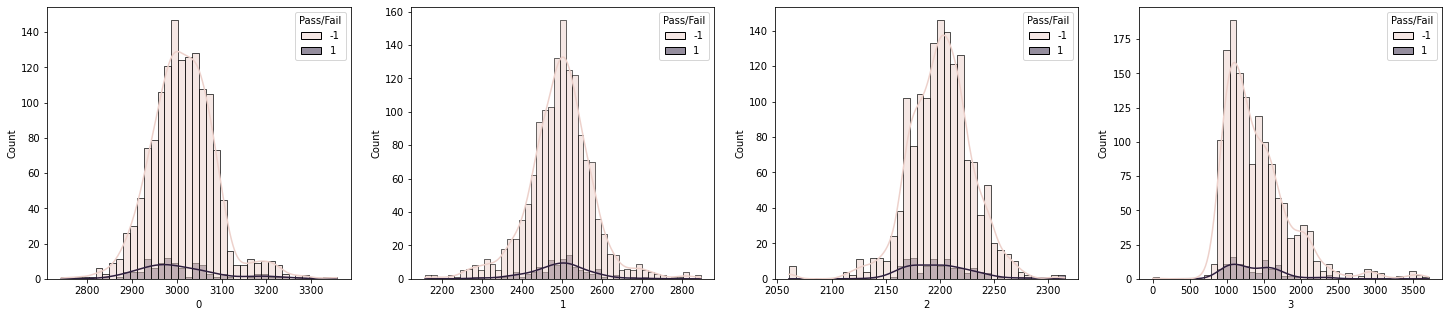

In [33]:
plt.figure(figsize=(25, 5))

for i in enumerate(features):
    plt.subplot(1, 4, i[0]+1)
    sns.histplot(data=workingCopy, x=i[1], kde=True, hue='Pass/Fail')

# 4. Data pre-processing:

In [34]:
X = workingCopy.drop(labels=['Pass/Fail'], axis=1)
y = workingCopy['Pass/Fail']

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

We'll further divide the test set into validation set for hyper-parameter tuning.

In [36]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1, stratify=y_test)

In [37]:
print('Shape of X_train: {}'.format(X_train.shape))
print('Shape of y_train: {}'.format(y_train.shape))
print('Shape of X_Validation: {}'.format(X_val.shape))
print('Shape of y_Validation: {}'.format(y_val.shape))
print('Shape of X_test: {}'.format(X_test.shape))
print('Shape of y_test: {}'.format(y_test.shape))

Shape of X_train: (940, 235)
Shape of y_train: (940,)
Shape of X_Validation: (313, 235)
Shape of y_Validation: (313,)
Shape of X_test: (314, 235)
Shape of y_test: (314,)


In [38]:
y_train.value_counts()

-1    878
 1     62
Name: Pass/Fail, dtype: int64

As we have found the train data set is imbalanced, we'll generate synthetic data for balancing the same.

In [39]:
from imblearn.over_sampling import RandomOverSampler

overSampler = RandomOverSampler(sampling_strategy='minority', random_state=2)

X_train, y_train = overSampler.fit_resample(X_train, y_train)

In [40]:
y_train.value_counts()

 1    878
-1    878
Name: Pass/Fail, dtype: int64

Now, our train data set has balanced target features.

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [42]:
X_scaled = scaler.fit_transform(X)

# 5. Model training, testing and tuning:

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.model_selection import cross_val_score

In [44]:
def model_testing(model, name:str):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('Model: {}'.format(name))
    
    print('')
    
    print('KFold Cross Validation:')
    kfold = KFold(n_splits=50)
    result = cross_val_score(model, X_val, y_val, cv=kfold, n_jobs=-1)
    
    print('KFold CV Accuracy: %.3f%% (%.3f%%)' % (result.mean()*100, result.std()*100))
    
    print('')
    
    print('LeaveOneOut Cross Validation:')
    leaveOneOut = LeaveOneOut()
    
    result = cross_val_score(model, X_val, y_val, cv=leaveOneOut, n_jobs=-1)
    
    print('LeaveOneOut CV Accuracy: %.3f%% (%.3f%%)' % (result.mean()*100, result.std()*100))
    
    print('')
    
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    
    print('')
    
    print('Confusion Metrics:')
    confusion_metrics = confusion_matrix(y_test, y_pred, labels=[1, -1])
    df_confusion_metrics = pd.DataFrame(confusion_metrics, index=['1', '-1'], columns=['Pred 1', 'Pred -1'])
    
    sns.heatmap(df_confusion_metrics, annot=True, fmt='g')

## Logistic Regression Model

Model: Logistic Regression Model

KFold Cross Validation:
KFold CV Accuracy: 92.905% (9.313%)

LeaveOneOut Cross Validation:
LeaveOneOut CV Accuracy: 92.971% (25.563%)

Classification Report:
              precision    recall  f1-score   support

          -1       0.97      0.67      0.79       293
           1       0.13      0.67      0.21        21

    accuracy                           0.67       314
   macro avg       0.55      0.67      0.50       314
weighted avg       0.91      0.67      0.75       314


Confusion Metrics:


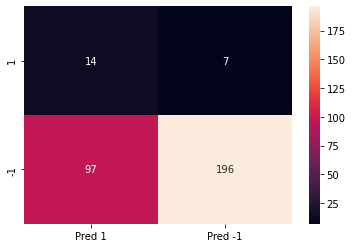

In [45]:
from sklearn.linear_model import LogisticRegression

LRModel = LogisticRegression(random_state=1, max_iter=1000)

model_testing(LRModel, 'Logistic Regression Model')

**Observations:**<br/>
From the results for the Logistic Regression Model we can observe
* Out of all the Passed scenarios, the model was able to predict 95 correctly where as 51 predicted as failed and out of all the failed scenarios 7 were predicted correctly and 4 were predicted wrongly.
* As per the accuracy score obtained from KFold cross validation, the model will perform at 92.833% confidence level with standard deviation of 13.541%
* As per the accuracy score obtained from LeaveOneOut cross validation, the model will perform at 92.994% confidence level with standard deviation of 25.525%.
* As here our goal is to identify/predict the fail scenario correctly to reduce the operation cost, we'll go with Precision(Recall) as we want to decrease the False Positive rate for the Test Fail(i.e. 1) class. From the above model we are getting recall value of 0.64 for the test fail class.

## Support Vector Classifier:

Model: Support Vector Classifier

KFold Cross Validation:
KFold CV Accuracy: 93.190% (9.307%)

LeaveOneOut Cross Validation:
LeaveOneOut CV Accuracy: 93.291% (25.018%)

Classification Report:
              precision    recall  f1-score   support

          -1       0.95      0.84      0.89       293
           1       0.15      0.38      0.21        21

    accuracy                           0.81       314
   macro avg       0.55      0.61      0.55       314
weighted avg       0.90      0.81      0.85       314


Confusion Metrics:


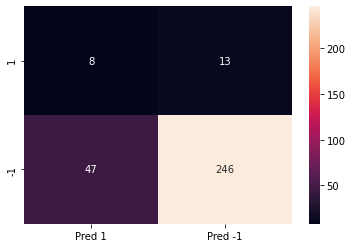

In [46]:
from sklearn.svm import SVC

svc = SVC(C=0.1, max_iter=1000, gamma='scale', random_state=1)

model_testing(svc, 'Support Vector Classifier')

**Observations:**<br/>
From the results for the Support Vector Classifier Model we can observe
* Out of all the Passed scenarios, the model was able to predict 117 correctly where as 29 predicted as failed and out of all the failed scenarios 4 were predicted correctly and 7 were predicted wrongly.
* As per the accuracy score obtained from KFold cross validation, the model will perform at 93.5% confidence level with standard deviation of 13.048%
* As per the accuracy score obtained from LeaveOneOut cross validation, the model will perform at 93.631% confidence level with standard deviation of 24.421%.
* As here our goal is to identify/predict the fail scenario correctly to reduce the operation cost, we'll go with Precision(Recall) as we want to decrease the False Positive rate for the Test Fail(i.e. 1) class. From the above model we are getting recall value of 0.36 for the test fail class which is less than the one obtained from Logistic Regression model.

## Decision Tree Classifier:

Model: Decision Tree Classifier

KFold Cross Validation:
KFold CV Accuracy: 88.429% (11.168%)

LeaveOneOut Cross Validation:
LeaveOneOut CV Accuracy: 85.942% (34.758%)

Classification Report:
              precision    recall  f1-score   support

          -1       0.92      0.24      0.38       293
           1       0.06      0.71      0.12        21

    accuracy                           0.27       314
   macro avg       0.49      0.47      0.25       314
weighted avg       0.86      0.27      0.36       314


Confusion Metrics:


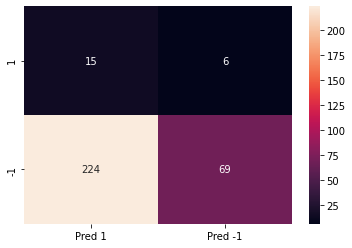

In [47]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)

model_testing(dtc, 'Decision Tree Classifier')

**Observations:**<br/>
From the results for the Decision Tree Classifier Model we can observe
* Out of all the Passed scenarios, the model was able to predict 79 correctly where as 67 predicted as failed and out of all the failed scenarios 10 were predicted correctly and 1 were predicted wrongly.
* As per the accuracy score obtained from KFold cross validation, the model will perform at 89.667% confidence level with standard deviation of 15.144%
* As per the accuracy score obtained from LeaveOneOut cross validation, the model will perform at 88.535% confidence level with standard deviation of 31.860%.
* As here our goal is to identify/predict the fail scenario correctly to reduce the operation cost, we'll go with Precision(Recall) as we want to decrease the False Positive rate for the Test Fail(i.e. 1) class. From the above model we are getting recall value of 0.91 for the test fail class which is better than the one obtained from Logistic Regression model.

## KNN Classifier:

Model: KNN Classifier

KFold Cross Validation:
KFold CV Accuracy: 93.190% (9.307%)

LeaveOneOut Cross Validation:
LeaveOneOut CV Accuracy: 93.291% (25.018%)

Classification Report:
              precision    recall  f1-score   support

          -1       0.97      0.52      0.68       293
           1       0.11      0.81      0.19        21

    accuracy                           0.54       314
   macro avg       0.54      0.66      0.43       314
weighted avg       0.92      0.54      0.64       314


Confusion Metrics:


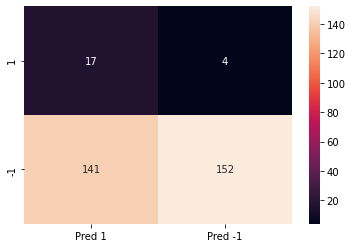

In [48]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)

model_testing(knn, 'KNN Classifier')

**Observations:**<br/>
From the results for the KNN Classifier Model we can observe
* Out of all the Passed scenarios, the model was able to predict 73 correctly where as 73 predicted as failed and out of all the failed scenarios 9 were predicted correctly and 2 were predicted wrongly.
* As per the accuracy score obtained from KFold cross validation, the model will perform at 93.5% confidence level with standard deviation of 13.048%
* As per the accuracy score obtained from LeaveOneOut cross validation, the model will perform at 93.631% confidence level with standard deviation of 24.421%.
* As here our goal is to identify/predict the fail scenario correctly to reduce the operation cost, we'll go with Precision(Recall) as we want to decrease the False Positive rate for the Test Fail(i.e. 1) class. From the above model we are getting recall value of 0.82 for the test fail class.

**Model Selection:**<br/>
By comparing the above models by their accuracy score from KFold and LeaveOneOut cross validations, their Recall value for the Fail class(i.e. 1), we'll go with the Decision Tree Classifier Model. 

### HyperParameter Tuning:

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
hyper_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 5]
}

tuning1 = GridSearchCV(estimator=dtc, param_grid=hyper_param, verbose=1, n_jobs=-1)

tuning1.fit(X=X_train, y=y_train)

tuning1.best_params_, tuning1.best_score_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


({'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2},
 0.8508077570577571)

Let's try the Decision Tree Classifier with the suggested hyper parameters and check the performance.

Model: Decision Tree Classifier

KFold Cross Validation:
KFold CV Accuracy: 89.571% (10.300%)

LeaveOneOut Cross Validation:
LeaveOneOut CV Accuracy: 89.457% (30.711%)

Classification Report:
              precision    recall  f1-score   support

          -1       0.94      0.65      0.77       293
           1       0.07      0.38      0.12        21

    accuracy                           0.63       314
   macro avg       0.50      0.52      0.45       314
weighted avg       0.88      0.63      0.73       314


Confusion Metrics:


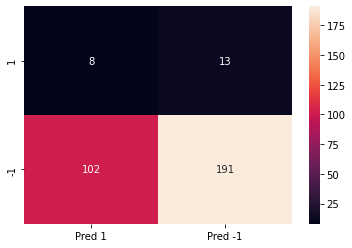

In [51]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=2, random_state=1)

model_testing(dtc, 'Decision Tree Classifier')

**Observations:**<br/>
By using the suggested hyper parameters by the GridSearchCV, there is slight decrease in the recall value for the Fail class(i.e. 1) but there is significant decrease in the number of misclassification of Passed semiconductors as Failed.

### Dimensionality Reduction:

In [52]:
from sklearn.decomposition import PCA

X = workingCopy.drop(labels='Pass/Fail', axis=1)
y = workingCopy['Pass/Fail']

X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=150)
pca.fit(X_scaled)

PCA(n_components=150)

In [53]:
print(pca.explained_variance_)

[8.77947623 6.6704882  5.52520566 5.21769996 4.36223808 3.97380123
 3.83349422 3.62865869 3.53028137 3.31199947 3.20770039 3.07844718
 2.89266333 2.86301252 2.72576138 2.57688403 2.52990541 2.46302557
 2.37506622 2.35771499 2.31493536 2.24523173 2.21131879 2.15822991
 2.1321649  2.07239145 2.05899873 2.03102264 2.01183761 1.94492459
 1.92473642 1.88701213 1.85142324 1.84596599 1.83400868 1.78439407
 1.77032091 1.74757118 1.72259215 1.69865509 1.68320732 1.66235526
 1.6318005  1.61131352 1.57710647 1.56701857 1.55410635 1.52989517
 1.51766538 1.49286177 1.46976613 1.46037553 1.41833159 1.39607752
 1.36730277 1.34388115 1.31681669 1.30832679 1.29092195 1.27882882
 1.25311171 1.25098442 1.22321872 1.21291943 1.20733785 1.19395617
 1.18371839 1.17346098 1.16621066 1.15139174 1.1400556  1.1322891
 1.11639812 1.10705141 1.101867   1.08196045 1.07512527 1.06022173
 1.0466237  1.0347005  1.02254118 1.00910702 1.00046067 0.98625234
 0.96821475 0.96451161 0.94990133 0.94210143 0.94137301 0.92984

In [54]:
print(sum(pca.explained_variance_ratio_))

0.9260571401963766


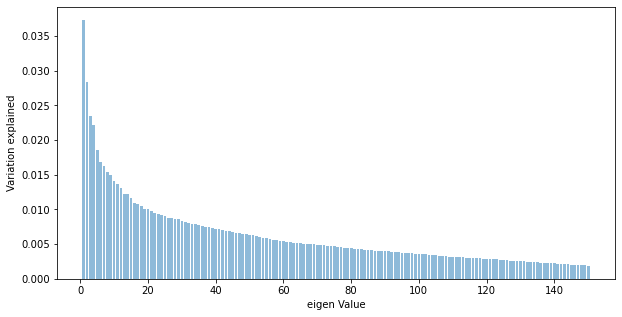

In [55]:
plt.figure(figsize=(10,5))
plt.bar(list(range(1,151)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

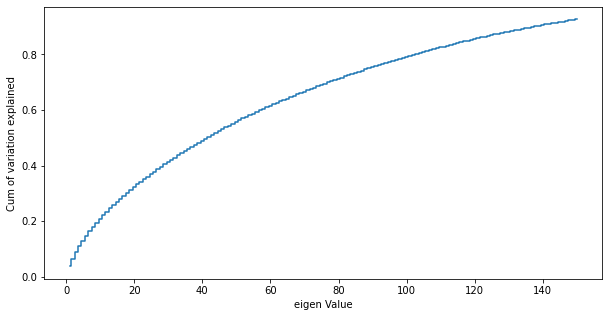

In [56]:
plt.figure(figsize=(10,5))
plt.step(list(range(1,151)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

**Observations:**<br/>
As we can see, by reducing the number of independent features from 235 to 150 but still we are able to explain 92% variation in the data. We'll go ahead with 150 components generated from PCA for model building.

In [57]:
pca150 = PCA(n_components=150)
pca150.fit(X_scaled)
print(pca150.components_)
print(pca150.explained_variance_ratio_)
Xpca150 = pca150.transform(X_scaled)
Xpca150.shape

[[ 0.04263362 -0.00487081 -0.0123872  ...  0.04592658 -0.01627291
  -0.02568106]
 [-0.01999054 -0.00163732 -0.0043374  ... -0.02810323  0.0249445
   0.04081739]
 [-0.01491799  0.02149589  0.00629279 ...  0.01523772 -0.01400059
   0.01212559]
 ...
 [ 0.04329172  0.07685194  0.05997817 ...  0.05051116  0.00353749
   0.01612382]
 [ 0.04602842  0.04334859 -0.19353527 ...  0.03164364  0.01981943
   0.0081585 ]
 [ 0.01408579 -0.07191322 -0.00128512 ... -0.00408908  0.01814363
  -0.03989376]]
[0.03733563 0.02836694 0.02349651 0.02218881 0.01855087 0.016899
 0.01630233 0.01543125 0.01501289 0.01408462 0.01364108 0.01309142
 0.01230135 0.01217526 0.01159158 0.01095847 0.01075868 0.01047427
 0.01010021 0.01002643 0.0098445  0.00954808 0.00940386 0.0091781
 0.00906725 0.00881306 0.0087561  0.00863713 0.00855555 0.00827099
 0.00818514 0.00802472 0.00787336 0.00785016 0.00779931 0.00758833
 0.00752847 0.00743173 0.0073255  0.00722371 0.00715801 0.00706934
 0.0069394  0.00685227 0.00670679 0.0066639

(1567, 150)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(Xpca150, y, test_size=0.4, stratify=y, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1, stratify=y_test)

In [59]:
print('Shape of X_train: {}'.format(X_train.shape))
print('Shape of y_train: {}'.format(y_train.shape))
print('Shape of X_Validation: {}'.format(X_val.shape))
print('Shape of y_Validation: {}'.format(y_val.shape))
print('Shape of X_test: {}'.format(X_test.shape))
print('Shape of y_test: {}'.format(y_test.shape))

Shape of X_train: (940, 150)
Shape of y_train: (940,)
Shape of X_Validation: (313, 150)
Shape of y_Validation: (313,)
Shape of X_test: (314, 150)
Shape of y_test: (314,)


In [60]:
y_train.value_counts()

-1    878
 1     62
Name: Pass/Fail, dtype: int64

As we have found the train data set is imbalanced, we'll generate synthetic data for balancing the same.

In [61]:
from imblearn.over_sampling import RandomOverSampler

overSampler = RandomOverSampler(sampling_strategy='minority', random_state=2)

X_train, y_train = overSampler.fit_resample(X_train, y_train)

In [62]:
y_train.value_counts()

 1    878
-1    878
Name: Pass/Fail, dtype: int64

Model: Decision Tree Classifier

KFold Cross Validation:
KFold CV Accuracy: 88.762% (11.259%)

LeaveOneOut Cross Validation:
LeaveOneOut CV Accuracy: 86.901% (33.739%)

Classification Report:
              precision    recall  f1-score   support

          -1       0.94      0.83      0.88       293
           1       0.11      0.29      0.15        21

    accuracy                           0.79       314
   macro avg       0.52      0.56      0.52       314
weighted avg       0.89      0.79      0.83       314


Confusion Metrics:


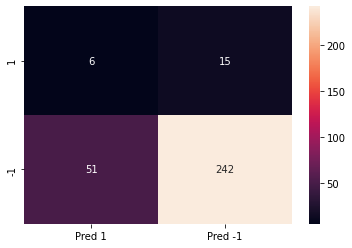

In [63]:
dtc2 = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=2, random_state=1)
model_testing(dtc2, 'Decision Tree Classifier')

**Observations:**<br/>
As we can see post dimension reduction the performance if the model has decreased marginally. There recall value for the Fail Class(i.e. 1) has reducded.

In [64]:
# Pickle the selected model for future use
import pickle

with open('DTC_Model.pkl', 'wb') as file:
    pickled_model = pickle.dump(dtc, file)

In [65]:
futureData = pd.read_excel('Future_predictions.xlsx')

In [66]:
futureData.columns = independent_feature_columns

In [67]:
futureData.shape

(18, 591)

In [68]:
futureData.head()

Time        0        1          2          3       4    5  \
0 2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100   
1 2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100   
2 2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100   
3 2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100   
4 2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100   

          6       7       8  ...     580       581     582     583     584  \
0   97.6133  0.1242  1.5005  ...     NaN       NaN  0.5005  0.0118  0.0035   
1  102.3433  0.1247  1.4966  ...  0.0060  208.2045  0.5019  0.0223  0.0055   
2   95.4878  0.1241  1.4436  ...  0.0148   82.8602  0.4958  0.0157  0.0039   
3  104.2367  0.1217  1.4882  ...  0.0044   73.8432  0.4990  0.0103  0.0025   
4  100.3967  0.1235  1.5031  ...     NaN       NaN  0.4800  0.4766  0.1045   

       585     586     587     588       589  
0   2.3630     NaN     NaN     NaN       NaN  
1   4.4447  0.0096  0.0201  0.0060  208.2045  
2   3.1745  0.0584  0.0484  0.0148   82.8602  
3   2.0544  0.0202  0.0149  0.0044   73.8432  
4  99.3032  0.0202  0.0149  0.0044   73.8432  

[5 rows x 591 columns]

In [69]:
futureData = futureData.drop(labels=['Time'], axis=1)

In [70]:
futureData = futureData.drop(labels=column_with_missing_data, axis=1)

for column in futureData.columns:
    futureData[[column]] = contFeatureImputer.transform(futureData[[column]])
    
futureData = futureData.drop(labels=unique_col_list, axis=1)

futureData = futureData.drop(labels=correlated_features_list, axis=1)

In [71]:
futureData.head()

0        1          2          3       4         6       7       8  \
0  3030.93  2564.00  2187.7333  1411.1265  1.3602   97.6133  0.1242  1.5005   
1  3095.78  2465.14  2230.4222  1463.6606  0.8294  102.3433  0.1247  1.4966   
2  2932.61  2559.94  2186.4111  1698.0172  1.5102   95.4878  0.1241  1.4436   
3  2988.72  2479.90  2199.0333   909.7926  1.3204  104.2367  0.1217  1.4882   
4  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.3967  0.1235  1.5031   

        9      10  ...      565       570     571    572     573     582  \
0  0.0162 -0.0034  ...  71.9005  533.8500  2.1113   8.95  0.3157  0.5005   
1 -0.0005 -0.0148  ...  71.9005  535.0164  2.4335   5.92  0.2653  0.5019   
2  0.0041  0.0013  ...   0.6219  535.0245  2.0293  11.21  0.1882  0.4958   
3 -0.0124 -0.0033  ...   0.1630  530.5682  2.0253   9.33  0.1738  0.4990   
4 -0.0031 -0.0072  ...  71.9005  532.0155  2.0275   8.83  0.2224  0.4800   

      583      586      587       589  
0  0.0118  71.9005  71.9005   71.9005  
1  0.0223   0.0096   0.0201  208.2045  
2  0.0157   0.0584   0.0484   82.8602  
3  0.0103   0.0202   0.0149   73.8432  
4  0.4766   0.0202   0.0149   73.8432  

[5 rows x 235 columns]

In [72]:
futureData_Predict = dtc.predict(futureData)

In [73]:
print('Future Predictions: ')
futureData_Predict

Future Predictions: 


array([-1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
       -1])

# 6. Conclusion and improvisation:

* There were few independent features for which more than 50% data collected were missing. This should be confirmed if this was data entry mistake.
* There is imbalance in the target variable(i.e. Pass/Fail). For the model building we have generated synthesized data for the minority class but if more data can be collected for the Fail Class then we can get proper accuracy score and performance from the model.